In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [3]:
#setting option to display full content rather than truncating at 50 characters
#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_colwidth', 50)
sns.set()

# Data Storytelling pt.2

In [4]:
#import all datasets
df_pop = pd.read_csv('data/df_pop.csv')
df_name = pd.read_csv('data/df_name0.csv')
df_pr = pd.read_csv('data/df_pr0.csv')


In [5]:
df_pop.columns

Index(['Unnamed: 0', 'tconst', 'primaryTitle', 'isAdult', 'startYear',
       'runtimeMinutes', 'genres', 'directors', 'writers', 'Romance',
       'Documentary', 'News', 'Sport', 'Biography', 'Drama', 'Crime',
       'Adventure', 'Fantasy', 'Comedy', 'War', 'Family', 'History', 'SciFi',
       'Western', 'Thriller', 'Mystery', 'Horror', 'Action', 'Music', 'Short',
       'Animation', 'Musical', 'FilmNoir', 'TalkShow', 'Adult', 'RealityTV',
       'GameShow', 'averageRating', 'numVotes', 'popularity'],
      dtype='object')

In [6]:
#we will truncate the dataframe to leave all the unneeded columns behind.
#this will help with the runtime of our code below during flagging
df_pop.drop(['Unnamed: 0','Romance',
       'Documentary', 'News', 'Sport', 'Biography', 'Drama', 'Crime',
       'Adventure', 'Fantasy', 'Comedy', 'War', 'Family', 'History', 'SciFi',
       'Western', 'Thriller', 'Mystery', 'Horror', 'Action', 'Music', 'Short',
       'Animation', 'Musical', 'FilmNoir', 'TalkShow', 'Adult', 'RealityTV',
       'GameShow'], axis=1, inplace=True)


In [7]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222860 entries, 0 to 222859
Data columns (total 11 columns):
tconst            222860 non-null object
primaryTitle      222860 non-null object
isAdult           222860 non-null int64
startYear         222860 non-null float64
runtimeMinutes    222860 non-null float64
genres            222860 non-null object
directors         222860 non-null object
writers           198671 non-null object
averageRating     222860 non-null float64
numVotes          222860 non-null int64
popularity        222860 non-null float64
dtypes: float64(4), int64(2), object(5)
memory usage: 18.7+ MB


In [8]:

top5genres = ['romance','drama','documentary','thriller','action']

#we are flagging only the movies that contain any of the above genres.
def flagit(df):
    
    df['flag']=0
    df['new_genres']=''
    df['genres']=df['genres'].str.lower()
    
    for index,row in df.iterrows():
        flag=0
        print(index)
        movie_genre = row['genres'].split(',')
        #print(movie_genre)

        no_genre=[]
        
        for genre in movie_genre:

        	if genre in top5genres:
        		flag =1

        	else :
        		no_genre.append(genre)
            
        
        if flag ==1:
            combined_genre = ",".join(sorted(list(set(movie_genre) - set(no_genre))))
            #print('combined is ',combined_genre)
            df.new_genres[index]=combined_genre
        
        df.flag[index]=flag
        #print('flag is',flag)
        
        
        #print('flag is '+ str(df.flag[index]))
    return df


From our previous observation, we noticed there are mainly top few genres that are truly noticeable and these genres were always included in the top movies.  As most of the movies consists or are comprised of these genres and a few extra, we will derive out these genres only so we can reduce the number of genre combinations that currently ranges over 1000 to 23 as part of our efforts in reducing the features that have very little weight to finding our end goal which is to find out the genres that mostly frequently provides the highest rating or gain popularity.

The code above took a long time to run for df_pop.  This part was run through the computer's terminal than through jupyter notebook.

In [29]:
new_pop=pd.read_csv('data/new_pop.csv')

In [30]:
new_pop=new_pop[new_pop.flag==1]


In [31]:
new_pop.new_genres.unique().size

23

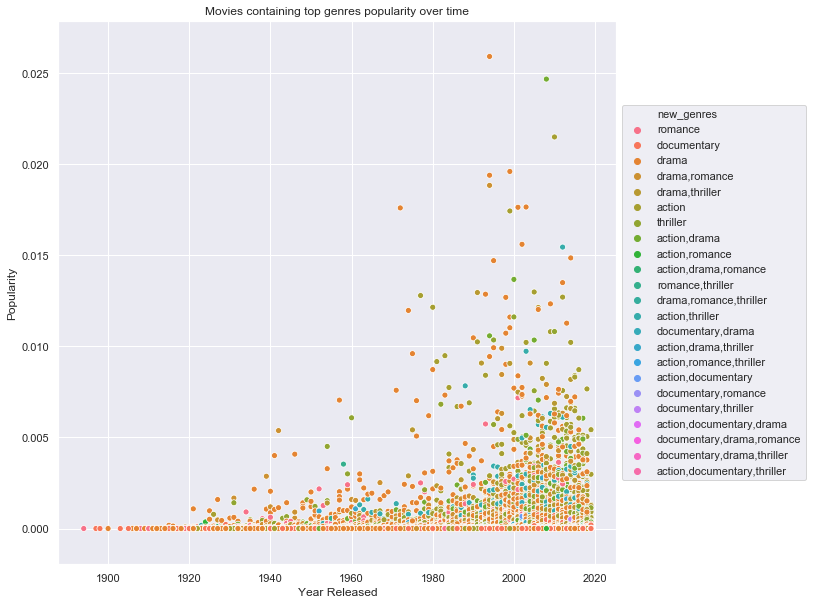

In [32]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='startYear',y='popularity',data=new_pop,hue='new_genres')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Movies containing top genres popularity over time')
plt.xlabel('Year Released')
plt.ylabel('Popularity')
plt.show()

Disregarding the movies that have relatively lower popularity score (<.005), we can see that there are quite even distribution of genres: documentary, drama, action adn thriller.

Let's look into this further.

In [39]:
decent_pop = new_pop[new_pop.popularity>0.005]

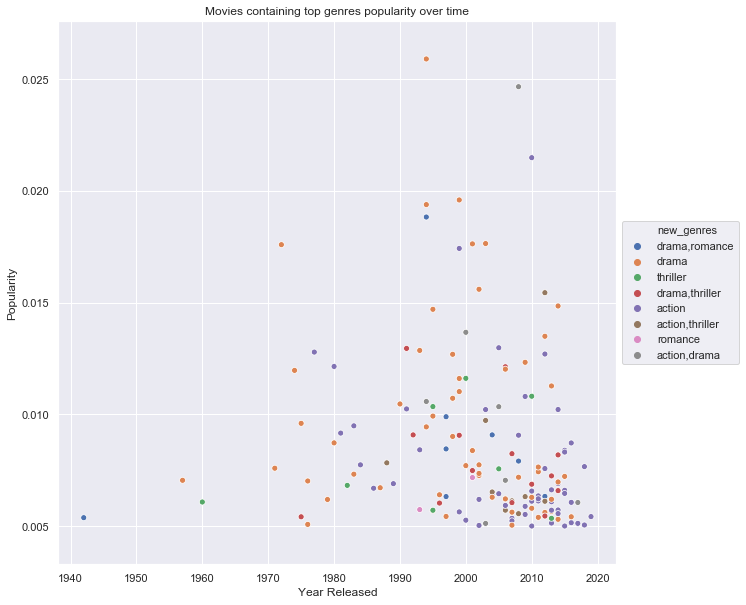

In [40]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='startYear',y='popularity',data=decent_pop,hue='new_genres')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Movies containing top genres popularity over time')
plt.xlabel('Year Released')
plt.ylabel('Popularity')
plt.show()

We reduced the number of genre combinations to 8 now. Drama is definitely the leading genre component that is embedded in almost all of the popular films.  We can see there are quite a lot of orange data points that is just 'Drama' but this is due to our feature engineering done just before. So these orange Drama data points can be a mixture of Drama genre and any other lesser used genre components like Fantasy or Sci-Fi.  We will look into this further in the later section.

Next, we can see the increase in the amount of popular action films through history.  The Drama genre distribution is very consistent throughout so we can assume that Drama genre is a somewhat 'backbone' of good film production.  
However, we have not been seeing a lot of popular action films until late 1970's. And since then until 2019, we can see it has become the 2nd most included genre in our 'popular' films.  This is represented by the purple, gray and brown data points that we can see a lot more from 2000-2020.  By the late 2010's, we are even seeing more action type films over drama type films.

Let's take a deeper dive into the drama type films first.


In [67]:
#extract from decent_pop dataframe, only the movies with drama associated with it
drama_only = decent_pop[decent_pop.new_genres == 'drama']

In [68]:
drama_only['drama']=''

/Users/byungchankim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [70]:
#iterate through the drama_only movies and derive the secondary genres associated with them
for index,row in drama_only.iterrows():
    
    #if the genre is drama only, we keep it
    if row['genres']=='drama':
        drama_only.drama[index]='drama'
    
    else:
        genre_list = row['genres'].split(',')
        
        genre_list.remove('drama')
        """
        if 'action' in genre_list:
            genre_list.remove('action')
        if 'thriller' in genre_list:
            genre_list.remove('thriller')
        if 'documentary' in genre_list:
            genre_list.remove('documentary')
        if 'romance' in genre_list:
            genre_list.remove('romance')
        """
        if len(genre_list) == 0:
            drama_only.drama[index]='drama'
        else:
            
            drama_only.drama[index]=",".join(sorted(genre_list))
        
        
    

/Users/byungchankim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/byungchankim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [71]:
drama_only.drama.unique().size

24

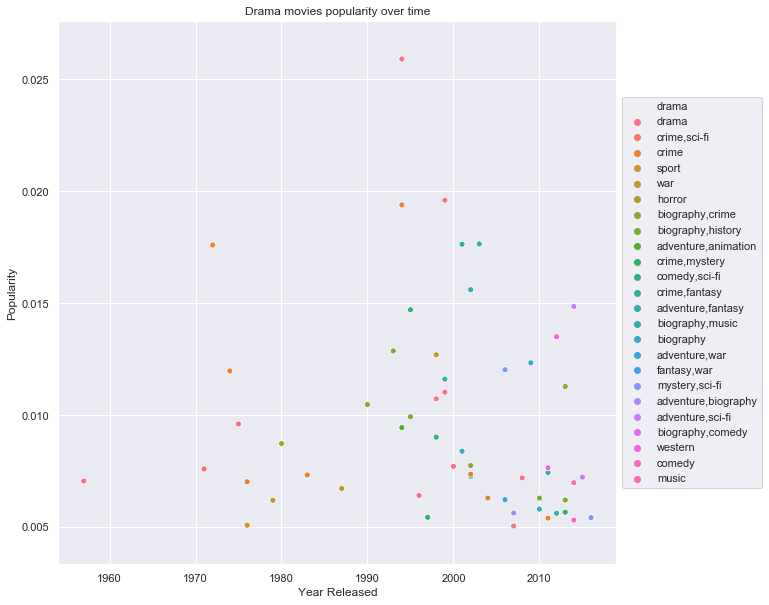

In [73]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='startYear',y='popularity',data=drama_only,hue='drama')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Drama movies popularity over time')
plt.xlabel('Year Released')
plt.ylabel('Popularity')
plt.show()

For the chart above, we took the Drama movies that we picked for decent_pop and showed only the remaining genres.  So these data points are all under Drama genres but the genre itself can be embedded in different flavors of defining genre components.

Looking at the chart above, it is noticeable that there were more movies with ideas of War, Crime, Biography and History related popular movies until the 1980's.  Then the trend changes to more of Crime, Fantasy, Adventures and Mystery until the latter half of 2000's.  From then on until now, we are seeing a lot more of Sci-fi, Fantasy, Adventure and Comedy.


In the early years of film production, the CGI technology was not readily available and very expensive. The first movie to adopt CGI was in 1973's Westworld.  In this era, practical effects were mainly used and because of the limited CGI capabilities, popular movies were mostly based on very real or historical events or storylines that did not involve a lot of computer generated images.

Near 2000's, CGI capabilities enhanced by a lot and this was an era where there were a good mix of both practical effects and CPI.  This allowed production companies to create vast scale images or other worldly scenes and adding CGI on top of practical effects were mostly used to create very real looking effects. This opened the door for directors to bring the great fantasy novels to life.  

Nowadays, CGI is used in almost all movies to a point it is difficult to find movies that do not utilize it.  Some movies are shot almost exclusively in front of green screens.  With these technological advances, what the audiences see on screen could be whatever the director imagined.  This created a boom of sci-fi films that dive into crazy scientific theories and introduction of highly advanced techs on screen all taken place in environments all up to director's imagination. 

In [74]:
action_only = decent_pop[decent_pop.new_genres.str.contains('action')]

In [76]:
action_only['action']=''

/Users/byungchankim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [77]:
#iterate through the action_only movies and derive the secondary genres associated with them
for index,row in action_only.iterrows():
    
    #if the genre is drama only, we keep it
    if row['genres']=='action':
        action_only.action[index]='action'
    
    else:
        genre_list = row['genres'].split(',')
        
        genre_list.remove('action')
        """
        if 'action' in genre_list:
            genre_list.remove('action')
        if 'thriller' in genre_list:
            genre_list.remove('thriller')
        if 'documentary' in genre_list:
            genre_list.remove('documentary')
        if 'romance' in genre_list:
            genre_list.remove('romance')
        """
        if len(genre_list) == 0:
            action_only.action[index]='action'
        else:
            
            action_only.action[index]=",".join(sorted(genre_list))
        
        
    

/Users/byungchankim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


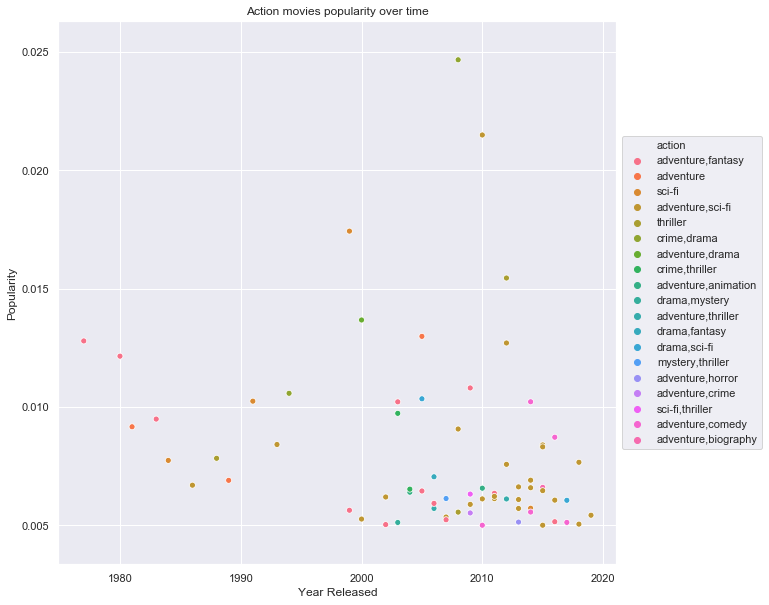

In [81]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='startYear',y='popularity',data=action_only,hue='action')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Action movies popularity over time')
plt.xlabel('Year Released')
plt.ylabel('Popularity')
plt.show()

With the action movies, we can see they are almost dominated by adventure and sci-fi in the modern film making era which is what we expected from the previous drama only movies investigation.  It also looks like action movies are likely to be paired with Adventure genre which makes sense as for an action film as it is important for charactors to express these "actions" in different places.  



With these data, we can say that film containing Action, Drama, and Sci-fi will have higher chance of getting more traction in the theater.

In the previous analysis, we found the top 20 directors that published popular movies.

From top:
Christopher Nolan , Frank Darabont , John Lasseter , Tim Miller , Lee Unkrich , David Fincher , Quentin Tarantino , James Cameron , Andrew Stanton , Joss Whedon , Peter Jackson , George Lucas , J.J. Abrams , James Gunn , Neill Blomkamp , Matthew Vaughn , Mel Gibson , Zack Snyder , Sam Mendes , Bryan Singer 

These directors are mostly from modern era as this list was derived from the popularity score which lies heavily on the number of votes and less on the rating itself.  Movie industry has expanded immensely since decades ago and a lot more people have obviously voted for the recent movies than the old.

In [83]:
#inner join on the directors column containing nconst
decent_dir = pd.merge(left=decent_pop,right=df_name, left_on='directors', right_on='nconst')

In [96]:
decent_dir.nlargest(20,['popularity'])[['primaryName','primaryTitle','genres']]

,primaryName,primaryTitle,genres
48,Frank Darabont,The Shawshank Redemption,drama
78,Christopher Nolan,The Dark Knight,"action,crime,drama"
82,Christopher Nolan,Inception,"action,adventure,sci-fi"
53,David Fincher,Fight Club,drama
41,Quentin Tarantino,Pulp Fiction,"crime,drama"
46,Robert Zemeckis,Forrest Gump,"drama,romance"
68,Peter Jackson,The Lord of the Rings: The Return of the King,"adventure,drama,fantasy"
67,Peter Jackson,The Lord of the Rings: The Fellowship of the Ring,"adventure,drama,fantasy"
6,Francis Ford Coppola,The Godfather,"crime,drama"
69,Peter Jackson,The Lord of the Rings: The Two Towers,"adventure,drama,fantasy"


The above shows the top 20 popular movies' director list.  We can see Christopher Nolan having the most movies in the top 20 with 5 movies.  Next, Peter Jackson takes the 2nd place in most movies in top 20 with his Lord of the Rings trilogy.  Next, we have David Fincher and Quentin Tarantino for Fight Club, Se7en and Pulp Fiction, Django Unchained respectively.

From this list, we can see that the Christopher Nolan's movies, which are all relatively new movies within a decade or slightly over, along with Peter Jackson, contains the combination of genres: Action, Drama, Sci-fi and Fantasy.